# Visualization

## Imports

In [12]:
import pickle
import pandas
from datetime import datetime
from matplotlib import pyplot as plt

## Load Data

In [13]:
from data_management.base_data_manager import BaseDataManager

files = [
    # "data_management/data/2024-03-19 Waage/2024-03-19_14-17-05_Waage - Robot 1_SPLIT_1.pkl",
    # "data_management/data/2024-03-19 Waage/2024-03-19_14-17-05_Waage - Robot 1_SPLIT_2.pkl",
    # "data_management/data/2024-03-19 Waage/2024-03-19_14-17-05_Waage - Robot 1_SPLIT_3.pkl",
    # "data_management/data/2024-03-19 Waage/2024-03-19_14-18-22_Waage - Robot 1_SPLIT_1.pkl",
    # "data_management/data/2024-03-19 Waage/2024-03-19_14-18-22_Waage - Robot 1_SPLIT_2.pkl",
    "data_management/data/2024-03-19 Waage/2024-03-19_14-18-22_Waage - Robot 1_SPLIT_3.pkl",
]

data = BaseDataManager.get_demonstrations_from_files(files)

### Transform Data into Dataframe

**Note:** additional features for the end-effector position, velocity and forces are calculated.
For the position and velocity the forward kinematics of the Pinocchio robot model are used.
The end-effector forces are calculated from the joint torques (friction is ignored) using the Jacobian:
$$\begin{aligned} 
\tau(t) &= J_f^T(\theta(t))\cdot F(t) \\
\Leftrightarrow F(t) &= J_f^{-T}(\theta(t))\cdot \tau(t)
\end{aligned}$$
- $\tau(t)$: joint torques
- $J_f(\theta(t))$: Jacobian
- $\theta(t)$: joint positions
- $F(t)$: end-effector forces

In [20]:
import tempfile

import torch
from torchcontrol.models import RobotModelPinocchio
from torchcontrol.utils import to_tensor

data_frames = dict()
with open("data_management/robot_metadata.pkl", "rb") as file:
    metadata = pickle.load(file)

with tempfile.NamedTemporaryFile("w+") as urdf_file:
    urdf_file.write(metadata.urdf_file)
    urdf_file.flush()
    robot_model = RobotModelPinocchio(urdf_file.name, metadata.ee_link_name)

for record_name,record_content in data.items():
    record_name = record_name.rsplit('/',1)[-1]
    record_name = record_name.replace(".pkl", "")
    rows = []
    for record in record_content:
        row = {}
        # timestamp
        row["timestamp"] = datetime.fromtimestamp(record.timestamp.seconds + record.timestamp.nanos * 1e-9)
        # joint positions 
        for idx, joint_pos in enumerate(record.joint_positions):
            row[f"joint_{idx}_pos"] = joint_pos
        # joint velocities
        for idx, joint_vel in enumerate(record.joint_velocities):
            row[f"joint_{idx}_vel"] = joint_vel
        # joint torques
        # torques received from the controller server (copy of TorqueCommand.joint_torques)
        for idx, joint_torque in enumerate(record.joint_torques_computed):
            row[f"joint_{idx}_torque_computed"] = joint_torque
        # torques received from the controller server in the previous timestep
        for idx, joint_torque in enumerate(record.prev_joint_torques_computed):
            row[f"joint_{idx}_prev_torque_computed"] = joint_torque
        # torques after adding safety mechanisms in the previous timestep
        for idx, joint_torque in enumerate(record.prev_joint_torques_computed_safened):
            row[f"joint_{idx}_prev_torque_computed_safened"] = joint_torque
        # motor torques
        # measured torque signals from the robot motors
        for idx, motor_torque in enumerate(record.motor_torques_measured):
            row[f"motor_{idx}_torques_measured"] = motor_torque
        # measured external torques exerted on the robot motors
        for idx, motor_torque in enumerate(record.motor_torques_external):
            row[f"motor_{idx}_torques_external"] = motor_torque
        # desired torques signals from the robot motors
        for idx, motor_torque in enumerate(record.motor_torques_desired):
            row[f"motor_{idx}_torques_desired"] = motor_torque
        # end effector
        # forward kinematics
        ee_pos, ee_quat = robot_model.forward_kinematics(to_tensor(record.joint_positions))
        # end effector position
        row["ee_pos_x"] = ee_pos[0]
        row["ee_pos_y"] = ee_pos[1]
        row["ee_pos_z"] = ee_pos[2]
        # end effector orientation
        row["ee_quat_a"] = ee_quat[0]
        row["ee_quat_b"] = ee_quat[1]
        row["ee_quat_c"] = ee_quat[2]
        row["ee_quat_d"] = ee_quat[3]
        # forward dynamics
        ee_jacobian = robot_model.compute_jacobian(to_tensor(record.joint_positions))
        ee_jacobian_psuedo_inv = torch.pinverse(ee_jacobian)
        joint_torques = to_tensor(record.joint_torques_computed)
        ee_forces = ee_jacobian_psuedo_inv.T @ joint_torques
        row["ee_force_x"] = ee_forces[0]
        row["ee_force_y"] = ee_forces[1]
        row["ee_force_z"] = ee_forces[2]
        row["ee_torque_x"] = ee_forces[3]
        row["ee_torque_y"] = ee_forces[4]
        row["ee_torque_z"] = ee_forces[5]
        # latency of previous ControlUpdate call
        row["prev_controller_latency"] = record.prev_controller_latency_ms
        # boolean whether previous command packet is successfully transmitted
        row["prev_command_successful"] = record.prev_command_successful

        rows.append(row)
    data_frames[record_name] = pandas.DataFrame(rows)

for record_name, record_content in data_frames.items():
    print(f"{record_name}: \t{record_content.shape[0]} data points")
print(f"imported {sum([record_content.shape[0] for record_content in data_frames.values()])} data points in total")

2024-03-19_14-18-22_Waage - Robot 1_SPLIT_3: 	10483 data points
imported 10483 data points in total


## Plot Data

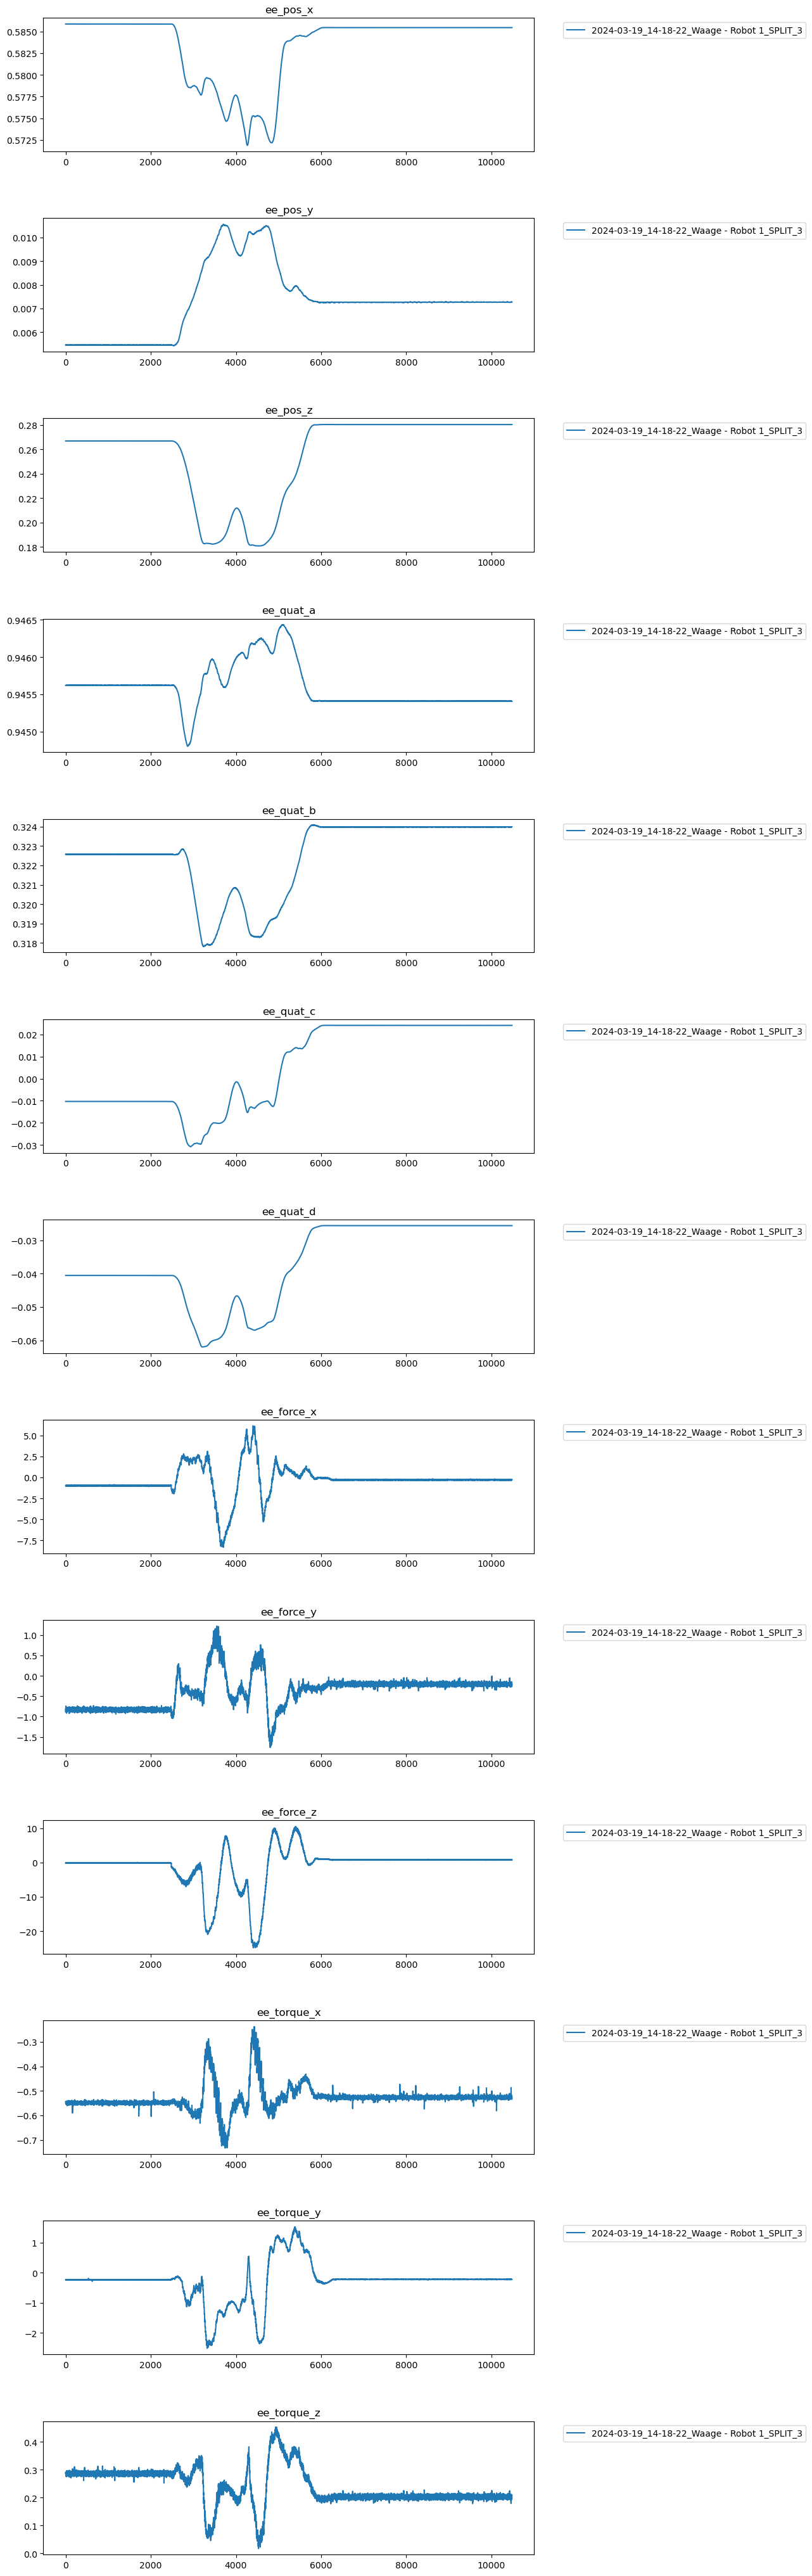

In [23]:
import textwrap
columns = [ # comment out the columns you don't want to plot
    # 'timestamp',
    # 'joint_0_pos', 'joint_1_pos', 'joint_2_pos', 'joint_3_pos', 'joint_4_pos', 'joint_5_pos', 'joint_6_pos', 
    # 'joint_0_vel', 'joint_1_vel', 'joint_2_vel', 'joint_3_vel', 'joint_4_vel', 'joint_5_vel', 'joint_6_vel', 
    # 'joint_0_torque_computed', 'joint_1_torque_computed', 'joint_2_torque_computed', 'joint_3_torque_computed', 'joint_4_torque_computed', 'joint_5_torque_computed', 'joint_6_torque_computed',
    # 'joint_0_prev_torque_computed', 'joint_1_prev_torque_computed', 'joint_2_prev_torque_computed', 'joint_3_prev_torque_computed', 'joint_4_prev_torque_computed', 'joint_5_prev_torque_computed', 'joint_6_prev_torque_computed', 
    # 'joint_0_prev_torque_computed_safened', 'joint_1_prev_torque_computed_safened', 'joint_2_prev_torque_computed_safened', 'joint_3_prev_torque_computed_safened', 'joint_4_prev_torque_computed_safened', 'joint_5_prev_torque_computed_safened', 'joint_6_prev_torque_computed_safened', 
    # 'motor_0_torques_measured', 'motor_1_torques_measured', 'motor_2_torques_measured', 'motor_3_torques_measured', 'motor_4_torques_measured', 'motor_5_torques_measured', 'motor_6_torques_measured',
    # 'motor_0_torques_external', 'motor_1_torques_external', 'motor_2_torques_external', 'motor_3_torques_external', 'motor_4_torques_external', 'motor_5_torques_external', 'motor_6_torques_external', 
    # 'motor_0_torques_desired', 'motor_1_torques_desired', 'motor_2_torques_desired', 'motor_3_torques_desired', 'motor_4_torques_desired', 'motor_5_torques_desired', 'motor_6_torques_desired',
    'ee_pos_x', 'ee_pos_y', 'ee_pos_z',
    'ee_quat_a', 'ee_quat_b', 'ee_quat_c', 'ee_quat_d',
    'ee_force_x', 'ee_force_y', 'ee_force_z',
    'ee_torque_x', 'ee_torque_y', 'ee_torque_z',
    # 'prev_controller_latency', 
    # 'prev_command_successful'
]
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 4*len(columns)))
plt.subplots_adjust(hspace=0.5)
if len(columns) == 1:
    axs = [axs]
for idx, column in enumerate(columns):
    axs[idx].set_title(column)
    for record_name in data_frames.keys():
        label = textwrap.fill(record_name, width=50)
        axs[idx].plot(data_frames[record_name][column], label=label)
    axs[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot
    # axs[idx].legend()

# Display the plot
plt.show()
